# Continuous Control

---

Congratulations for completing the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program!  In this notebook, you will learn how to control an agent in a more challenging environment, where the goal is to train a creature with four arms to walk forward.  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Crawler.app"`
- **Windows** (x86): `"path/to/Crawler_Windows_x86/Crawler.exe"`
- **Windows** (x86_64): `"path/to/Crawler_Windows_x86_64/Crawler.exe"`
- **Linux** (x86): `"path/to/Crawler_Linux/Crawler.x86"`
- **Linux** (x86_64): `"path/to/Crawler_Linux/Crawler.x86_64"`
- **Linux** (x86, headless): `"path/to/Crawler_Linux_NoVis/Crawler.x86"`
- **Linux** (x86_64, headless): `"path/to/Crawler_Linux_NoVis/Crawler.x86_64"`

For instance, if you are using a Mac, then you downloaded `Crawler.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Crawler.app")
```

In [2]:
env = UnityEnvironment(file_name='Crawler_Linux/Crawler.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states_ = env_info.vector_observations
state_size = states_.shape[1]


Number of agents: 12
Size of each action: 20


In [7]:
class Critic(nn.Module):
    def __init__(self, input_shape, layer_size):
        super(Critic, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, layer_size),
                                 nn.ReLU(),
                                 nn.Linear(layer_size,layer_size),
                                 nn.ReLU(),
                                 nn.Linear(layer_size, 1))
    
    def forward(self,x):
        x = self.net(x)
        return x
      
class Actor(nn.Module):
    def __init__(self, input_shape, output_shape,layer_size):
        super(Actor, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, layer_size),
                                 nn.ReLU(),
                                 nn.Linear(layer_size,layer_size),
                                 nn.ReLU(),
                                 )
        self.mean = nn.Sequential(nn.Linear(layer_size, output_shape),
                                  nn.Tanh())                    # tanh squashed output to the range of -1..1
        self.variance =nn.Sequential(nn.Linear(layer_size, output_shape),
                                     nn.Softplus())             # log(1 + e^x) has the shape of a smoothed ReLU
    
    def forward(self, x):
        x = self.net(x)    
        sigma = torch.sqrt(self.variance(x).cpu())
        m = Normal(self.mean(x).cpu(), sigma)
        actions = m.sample()
        actions = torch.clamp(actions, -1, 1) # usually clipping between -1,1 but pendulum env has action range of -2,2

        logprobs = m.log_prob(actions) #for the optimization step we create a new distribution based on the new mean and variance - still taking the logprobs based on the old actions!

    
        return actions, logprobs, m
    


In [8]:
class Agent():
    def __init__(self, state_size, action_size, ppo_epochs, mini_batch_size,\
                 layer_size,lr_a, lr_c, gamma, entropy_beta, clip_grad):
        self.state_size = state_size
        self.action_size = action_size
        
        self.layer_size = layer_size
        self.gamma = gamma
        self.entropy_beta = entropy_beta
        self.clip_grad = clip_grad
        
        self.ppo_epochs = ppo_epochs
        self.mini_batch_size = mini_batch_size
        
        self.actor = Actor(state_size, action_size,layer_size).to(device)
        self.critic = Critic(state_size,layer_size).to(device)
        self.a_optimizer = optim.RMSprop(params = self.actor.parameters(),lr = lr_a)
        self.c_optimizer = optim.RMSprop(params = self.critic.parameters(),lr = lr_c)
        
    def act(self, states):
        self.actor.eval()
        with torch.no_grad():
            actions, logprobs ,_ = self.actor(torch.from_numpy(states).float().to(device))
        self.actor.train()
        return actions.cpu().numpy(), logprobs
        

    def compute_returns(self,rewards_tensor, masks_tensor):
        output = []
        for rewards, masks in zip(rewards_tensor, masks_tensor):
            R = 0 
            returns = []
            for step in reversed(range(len(rewards))):
                R = rewards[step] + self.gamma * R * masks[step]
                returns.insert(0, R)
            output.append(returns)
        output = list(zip(*output))
        discounted_rewards = [torch.FloatTensor(i).unsqueeze(1) for i in output]
        return torch.cat(discounted_rewards)



    def ppo_iter(self, states, actions, log_probs, advantage, discounted_rewards):
        batch_size = len(states)#.shape[]

        for i in range(batch_size // self.mini_batch_size):
            rand_ids = np.random.randint(0, batch_size, self.mini_batch_size)

            yield torch.cat(states)[rand_ids], torch.cat(actions)[rand_ids], torch.cat(log_probs)[rand_ids], advantage[rand_ids], discounted_rewards[rand_ids]



    def ppo_update(self, states, actions, log_probs, advantage, discounted_rewards, eps_clip=0.2):
        """

        """

        a_loss_batch = []
        c_loss_batch = []
        entropy_batch = []

        for _ in range(self.ppo_epochs):
            for states_i, old_actions, old_logprobs, advantage_i, discounted_reward_i  in self.ppo_iter(states, actions, log_probs, advantage, discounted_rewards):

                self.c_optimizer.zero_grad()
                #tran critic
                new_value = self.critic(states_i.to(device))
                c_loss = F.mse_loss(new_value, discounted_reward_i).cpu()
                c_loss.backward(retain_graph=True)
                clip_grad_norm_(self.critic.parameters(),self.clip_grad)
                self.c_optimizer.step()

                c_loss_batch.append(c_loss.detach().cpu().numpy())


                #train actor
                self.a_optimizer.zero_grad()
                _, _, dist = self.actor(states_i.to(device))
                new_logprobs = dist.log_prob(old_actions)
                entropy = dist.entropy().mean()
                entropy_batch.append(entropy.detach().cpu().numpy())


                ratio = torch.exp(new_logprobs - old_logprobs.detach()).cpu()
                surr = ratio * advantage_i.cpu()
                clip = torch.clamp(ratio, 1.0 - eps_clip, 1.0 + eps_clip)

                
                a_loss  = - (torch.min(surr, clip * advantage_i.cpu() ).mean()) + self.entropy_beta * entropy.cpu()
                a_loss.backward(retain_graph=True)
                clip_grad_norm_(self.actor.parameters(),self.clip_grad)
                self.a_optimizer.step()

                a_loss_batch.append(a_loss.detach().cpu().numpy())


        return np.array(c_loss_batch).mean(), np.array(a_loss_batch).mean(), np.array(entropy_batch).mean()

def list_to_tensor(list_):
    return np.array(list(zip(*list_)))

Episode: 100 | mean_reward: 140.08 | min_reward: -6.54 | max_reward: 209.28 | Average_100: 112.86
Episode: 200 | mean_reward: 292.45 | min_reward: -34.37 | max_reward: 537.06 | Average_100: 190.93
Episode: 300 | mean_reward: 568.86 | min_reward: 79.10 | max_reward: 875.70 | Average_100: 376.571
Episode: 400 | mean_reward: 363.02 | min_reward: 178.80 | max_reward: 753.68 | Average_100: 379.09


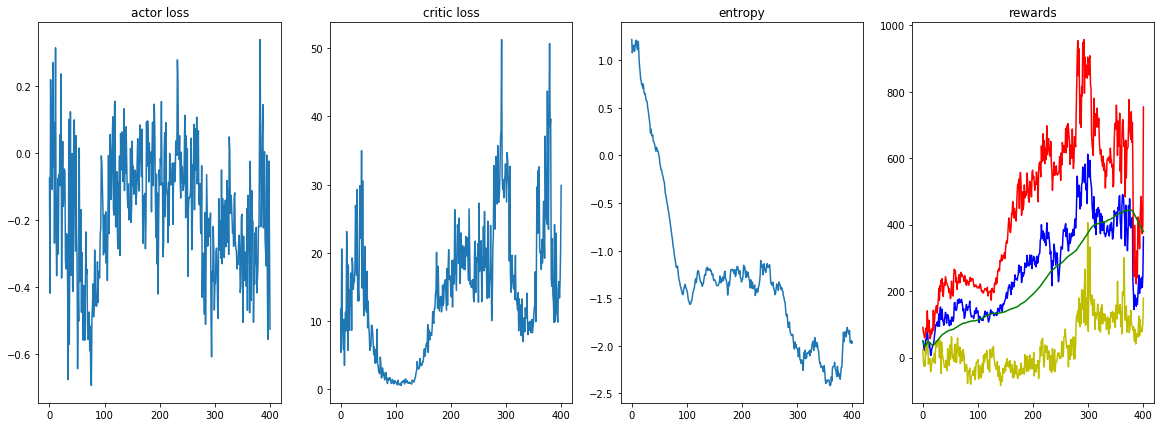

In [9]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
agent = Agent(state_size = state_size, action_size = action_size ,ppo_epochs = 5, mini_batch_size = 512,\
                 layer_size = 512 ,lr_a = 1e-4, lr_c = 1e-4, gamma = 0.99 , entropy_beta = 1e-4, clip_grad = 1)

max_episodes = 400

c_loss_list = []
a_loss_list = []
entropy_list = []


average_100 = deque(maxlen = 100)

mean_rewards = []
max_rewards = []
min_rewards = []
average_100_rewards = []

max_steps = 2024

for ep in range(max_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    done = False
    
    states_batch = []
    values_batch = []
    actions_batch = []
    logprobs_batch = []
    rewards_batch = []
    masks = []
    scores = np.zeros(num_agents)
    for step in range(max_steps):

        actions, logprobs  = agent.act(states)  
        values = agent.critic(torch.from_numpy(states).float().to(device))
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards
        
        states_batch.append(torch.from_numpy(states).float())      
        values_batch.append(values)
        logprobs_batch.append(logprobs)
        actions_batch.append(torch.from_numpy(actions))
        rewards_batch.append(rewards)  
        masks.append(np.ones_like(dones) - np.array(dones).astype(int))

        states = next_states

        if np.any(dones):
            env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
            states = env_info.vector_observations
            #break

    # calculate discounted rewards and advantage:
    rewards_tensor = list_to_tensor(rewards_batch)
    masks_tensor = list_to_tensor(masks)
    discounted_rewards = agent.compute_returns(rewards_tensor, masks_tensor).to(device)
    advantage = discounted_rewards - torch.cat(values_batch).detach() 
    # normalize advantage:
    advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-5)
    
    c_loss, a_loss, entropy = agent.ppo_update( states = states_batch, actions = actions_batch, log_probs = logprobs_batch, advantage = advantage, discounted_rewards = discounted_rewards)
    c_loss_list.append(c_loss)
    a_loss_list.append(a_loss)
    entropy_list.append(entropy)
    
    mean_rewards.append(np.mean(scores))
    min_rewards.append(np.min(scores))
    max_rewards.append(np.max(scores))
    average_100.append(np.mean(scores))
    average_100_rewards.append(np.array(average_100).mean())
    
    print("\rEpisode: {} | mean_reward: {:.2f} | min_reward: {:.2f} | max_reward: {:.2f} | Average_100: {:.2f}".format(ep, np.mean(scores), np.min(scores), np.max(scores), np.mean(average_100)), end = "", flush = True)
    if ep != 0 and ep % 100 == 0:
        print("\rEpisode: {} | mean_reward: {:.2f} | min_reward: {:.2f} | max_reward: {:.2f} | Average_100: {:.2f}".format(ep, np.mean(scores), np.min(scores), np.max(scores), np.mean(average_100)))
    if ep % 50 == 0:
        torch.save(agent.actor.state_dict(), "Crawler_weights/actor"+str(ep)+".pth")
        torch.save(agent.critic.state_dict(), "Crawler_weights/critic"+str(ep)+".pth")
        

    
env.close()
# PLOTTING RESULTS

plt.figure(figsize = (20,7))
plt.subplot(1,4,1)
plt.title("actor loss")
plt.plot(a_loss_list)
plt.subplot(1,4,2)
plt.title("critic loss")
plt.plot(c_loss_list)
plt.subplot(1,4,3)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,4,4)
plt.title("rewards")
plt.plot(mean_rewards, c = "b")
plt.plot(min_rewards, c = "y")
plt.plot(max_rewards, c = "r")
plt.plot(average_100_rewards, c = "g")
plt.show()